In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import fnmatch
from linfit import linfit
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column
from fakescorr import fakescorr
import os 


def foldering(path):
    if os.path.exists(path)==False:
        os.mkdir(path)
    return

#-------------------------------
#FFD
#-------------------------------
def print_susp(specs2, Tmin, Tmax,cluster, test,):
    select_suspicious = specs2[(specs2['T']>=Tmin) & (specs['T']<=Tmax)]
    for oid in select_suspicious.index.values:
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            continue
        plt.figure(figsize=(10,2))
        plt.plot(flux.time,(flux.flux_gap-flux.flux_model))
        for i, row in flares.iterrows():
            plt.plot(flux.time.iloc[row.istart:row.istop],
                     (flux.flux_gap-flux.flux_model).iloc[row.istart:row.istop],
                     linewidth=2,
                     color='red',)
            plt.title(oid)
    return

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    #model = pd.Series(np.asarray(flux_gap)[start:stop+1]).mean()
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = (flux - model)
 
    ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
#    myloc = loc + '_my_flares.txt'
#     try:
#         myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
#     except OSError:
#         myflares = []

    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    #print(flux.head())
    return flux, flares

def write_flares(forf,cluster, test, EPIC, typ='flares',extra=''):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares{}.csv'.format(loc,EPIC,extra))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed, ederr = ED(row['istart_no_sys_no_thruster'],
                       row['istop_no_sys_no_thruster'],
                       flux.time,flux.flux_model,flux.flux_gap)
        
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges


DM = lambda x: 5.*np.log10(float(x))-5. 

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    #color = ['red' if val in outliers else 'black'
    return color



def energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=False,onlyenergy=False):
    clusterenergy, clusterenergy_err, clustered, clusterederr, Teff, corr, edtrue = [], [], [], [], [], [], []
    dur = []
    L, Lerr, EPIC = [],[],[]
    for oid in oid_list:
        tmyed, tenergy, tenergy_err, tL, tLerr = [], [], [], [], []
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            continue
        L_bol = specs['L_quiet_bol'].loc[oid]
        L_bolerr = specs['L_quiet_bol_err'].loc[oid]
        L_quiet = specs['L_quiet'].loc[oid]
        L_quiet_err = specs['L_quiet_err'].loc[oid]
        if flares.empty:
             continue
        else:
            s_s = flares.dropna(how='any',subset=['istart_no_sys_no_thruster','istop_no_sys_no_thruster'])
            s_s['corrected'] = 1    
            teff =  specs['T'].loc[oid]
            for i,row in s_s.iterrows():
                ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                               row['istop_no_sys_no_thruster'],
                               flux.time,flux.flux_model,flux.flux_gap, flux.error)
                energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)
          
                if (ed != 'nan') & (ed > 0):
                    clusterenergy.append(ed*L_quiet)
                    clusterenergy_err.append(energy_err)
                    tenergy.append(ed*L_quiet)
                    tenergy_err.append(energy_err)
                    tmyed.append(ed)
                    tL.append(L_bol)
                    L.append(L_bol)
                    tLerr.append(L_bolerr)
                    Lerr.append(L_bolerr)
                    clustered.append(ed)
                    clusterederr.append(ederr)
                    Teff.append(teff)
                    EPIC.append(oid)
                    
                else:
                    clusterenergy.append(np.nan)
                    clusterenergy_err.append(np.nan)
                    tenergy.append(np.nan)
                    tenergy_err.append(np.nan)
                    tmyed.append(np.nan)
                    clustered.append(np.nan)
                    clusterederr.append(np.nan)
                    Teff.append(np.nan)
                    tL.append(np.nan)
                    L.append(np.nan)
                    tLerr.append(np.nan)
                    Lerr.append(np.nan)
                    EPIC.append(np.nan)

        s_s['myed'] = tmyed
        s_s['myenerg'] = tenergy
        s_s['myenerg_err'] = tenergy_err
        s_s['L_bol'] = tL
        s_s['L_bol_err'] = tLerr
        if (fakes==True) & (onlyenergy==False): 
      #      try:
            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
           # except (FileNotFoundError, IndexError):
           #     s_s['corrected'] = np.nan
        if (fakes==True) & (onlyenergy==True): 
      #      try:
            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
            s_s['count_true'] = 1
           # except (FileNotFoundError, IndexError):
           #     s_s['corrected'] = np.nan
        elif (fakes==False) & (onlyenergy==False): 
            s_s['count_true'] = 1
            s_s['energ_true'] = tenergy
        corr.append(list(s_s.count_true))
        edtrue.append(list(s_s.energ_true))
        
        
        filtered = fnmatch.filter(s_s.columns.values, 'Unnamed:*')
        s_s = s_s.drop(filtered,axis=1)

        write_flares(s_s, cluster, test, oid, typ='flares') 
    corr = [i for item in corr for i in item]
 
    edtrue = [i for item in edtrue for i in item]
    c = pd.DataFrame({'clusterenergy':clusterenergy,
                      'clusterenergy_err':clusterenergy_err,
                      'clustered':clustered,
                      'clusterederr':clusterederr,
                      'Teff':Teff,
                      'stars_in_bin':len(oid_list),
                      'Tmin':Tmin,'Tmax':Tmax,
                      'count_true': corr,
                      'energ_true':edtrue,
                      'L_bol':L,
                      'L_bol_err':Lerr,
                      'EPIC':EPIC})
    c['rel_energ_err']=c.clusterenergy_err/c.clusterenergy

    loc = 'stars_shortlist/share/clusterenergies_{0}_{1}_{2}_{3}.csv'.format(cluster,test,Tmin,Tmax)
#     if glob.glob(loc)==[]:
#         c.to_csv(loc)
#     else:
#         c_arch = pd.read_csv(loc,usecols=['clusterenergy','clusterenergy_err','clustered',
#                                      'clusterederr','Teff','stars_in_bin','Tmin','Tmax'])
#         c = c_arch.append(c)
    #c.to_csv(loc)
    return c

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) 
    return (ed * L_quiet_err) + (ederr * L_quiet)

def FFD(oid, cluster, test, specs,color='red'):
    flux, flares = import_flares(cluster, test, oid)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))




## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [2]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                #'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                #'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.120,136.]
               }

cluster ='M44'
basics = cluster_dict[cluster]
test = 'run_05'
C = '05'
LCtype = 'k2sc'
dm = DM(basics[4])
global dm
l = 'stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    print('Go back to step 6.')
    
specs[['T','T_err','L_quiet','L_quiet_err','L_quiet_bol_err']].sort_values(by='T').head(n=10)

['stars_shortlist/M44/M44_parameter.csv']


,T,T_err,L_quiet,L_quiet_err,L_quiet_bol_err
EPIC,,,,,
212006725,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211981687,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211887287,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211887567,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211981954,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211888866,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211939350,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
212066424,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27
211892816,3030,51.316014,8.021216e+28,2.551122e+28,1.160077e+27


In [3]:
#lowtemp = specs.index.values[specs['T']<4500]
fails = pd.read_csv('stars_shortlist/{}/results/{}/Lombscargle_fails.txt'.format(cluster, test),
                   header=None,index_col=0)
overlap = list(set(fails.index.values) & set(specs.index.values))
print(overlap)
params = specs.loc[overlap]
#flux, flares = import_flares(cluster, test, overlap[0])
# plt.figure(figsize=(10,2))
# plt.plot(flux.time,flux.flux_gap)
# for i, row in flares.iterrows():
#     plt.plot(flux.time.iloc[np.arange(row.istart,row.istop)],
#              flux.flux_gap.iloc[np.arange(row.istart,row.istop)],
#              linewidth=5,
#              color='red')
#flares.columns.values

[212112578, 211982727, 211899790, 212158768, 211972627, 211729756]


In [4]:
s2 = specs.drop(overlap)

s2.to_csv('M44_parameter2.csv')

In [5]:
flarelist = pd.read_csv('stars_shortlist/{0}/results/{1}/{0}_{1}_flarelist.txt'.format(cluster,test),
    delimiter='\t')
#flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',
                                                  ' Number of Flares ':'counts',
                                                  ' Total Exposure Time of LC in Days ':'dur'})
flarelist.dur = flarelist.dur*24.
flarelist = flarelist.drop_duplicates(subset='EPIC')
flarelist = flarelist.set_index('EPIC')
#specs=specs.drop('counts', axis=1)
specs = specs.join(flarelist, how='left')
specs.counts.head()


EPIC
211700306    0
211707676    0
211708110    2
211725787    0
211727975    0
Name: counts, dtype: int64

In [6]:
flarelist = flarelist[~flarelist[' Filename '].str.contains('everest')]
flarelist

,Date of Run,counts,Filename,dur,BJD-2454833 days
EPIC,,,,,
211700306,2018-05-17 12:27:09.806537,0,hlsp_k2sc_k2_llc_211700306-c05_kepler_v2_lc.fits,1556.443333,2306.631139
211707676,2018-05-17 12:28:50.211141,0,hlsp_k2sc_k2_llc_211707676-c05_kepler_v2_lc.fits,1557.346667,2306.631221
211708110,2018-05-17 12:28:54.185277,2,hlsp_k2sc_k2_llc_211708110-c05_kepler_v2_lc.fits,1556.443333,2306.631144
211725787,2018-05-17 12:28:58.632158,0,hlsp_k2sc_k2_llc_211725787-c05_kepler_v2_lc.fits,1557.346667,2306.631084
211727975,2018-05-17 12:29:02.956503,0,hlsp_k2sc_k2_llc_211727975-c05_kepler_v2_lc.fits,1556.895000,2306.631200
211729756,2018-05-17 12:29:08.103050,1,hlsp_k2sc_k2_llc_211729756-c05_kepler_v2_lc.fits,1546.958333,2306.631035
211734093,2018-05-17 12:29:12.308713,0,hlsp_k2sc_k2_llc_211734093-c05_kepler_v2_lc.fits,1555.540000,2306.631136
211738707,2018-05-17 12:29:16.382338,1,hlsp_k2sc_k2_llc_211738707-c05_kepler_v2_lc.fits,1555.088333,2306.631355
211745306,2018-05-17 12:29:20.263520,1,hlsp_k2sc_k2_llc_211745306-c05_kepler_v2_lc.fits,1555.991667,2306.631271


In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# build a rectangle in axes coords
left, width = 0.35, .5
bottom, height = 0.4, .5
right = left + width
top = bottom + height
# ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height,
#               fill=False,
#               )



# ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)


def Teff_count(specs,cluster):
    specs['logL'] = np.log10(specs.L_quiet)
    
    plot = specs.plot(x='T',y='logL',
                      kind = 'scatter', 
                      color='black',
                      s=list(specs['counts']**2),
                      marker='o',
                      alpha=0.2,
                      title = '{}'.format(cluster),)
                      #figsize=(7,7))
    plot.set_ylabel('log(L_quiet)')
    plot.set_xlabel('T_eff')
    #plot.text(6.5, 6.5cm, r'1 flare', fontsize=11)
    plt.plot(5900, 30.82, 'o', markersize=25,color='black')
    fig = plot.get_figure()
    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/Teff_{}_counts.jpg'.format(cluster),dpi=300)
    return

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    #drops = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades/redgiants.csv',
         #              header=None, names=['EPIC'])
    #print(drops.shape,specs.shape)
    #specs = specs.drop(drops.EPIC.tolist())
    #print(drops.shape,specs.shape)
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', color='black',
                     # color=color_outlier_red(specs.index.values,drops.EPIC),
                      s=list(specs['counts']**2./2),
                      title = '{}'.format(cluster),
                      alpha=0.5,figsize=(6,5))
    
    
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(right, top, r'5 flares', transform=plot.transAxes, fontsize=11)
    plot.plot(right-.03, top+0.016, 'o', markersize=25/2,color='black', transform=plot.transAxes)

    fig = plot.get_figure()
    ax = plt.gca()
    plt.Rectangle((left, bottom), width, height,
              fill=False,
              )
    plt.set_transform(ax.transAxes)
    plt.set_clip_on(False)
    #ax.add_patch(p)

    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

# CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(16,9))
#CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(16,9))
#CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(13,4))
# CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(14.5,8))#,text=(16.5))
Teff_count(specs,cluster)

In [ ]:
specs2 = specs.drop(overlap)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=7000.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=3249.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3250.) & (specs2['T']<=3499.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3500.) & (specs2['T']<=3749.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3750.) & (specs2['T']<=4000.)].dur.sum()/24/365)

In [7]:
def cum_hist_average(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax,fakes=False,onlyenergy=False):
    
    try:
        #normalize = 1./len(oid_list)
        c = energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=fakes,onlyenergy=onlyenergy)
        c = c.dropna(how='any')#,subset='clusterenergy')
        print('uncorrected ',c.shape)
        normalize = 1./(specs[specs.index.isin(oid_list)].dur.sum()*0.85)#the last factor accounts for removed thruster firings
        if ((fakes == True) & (onlyenergy==False)) :
            c = c.sort_values(by=['energ_true'])
            #print(c[c.count_true >= 7])
            c = c[c.count_true < 5.]
            hist_err = np.asarray(c.count_true**2)
            hist = np.ones_like(c.energ_true)
            print('corrected ',c.shape)
            
        elif ((fakes == True) & (onlyenergy==True)) :
            c = c.sort_values(by=['energ_true'])
            #c = c[c.count_true < 2.]
            hist = np.ones_like(c.energ_true)
            hist_err = np.ones_like(c.energ_true)**2
            hist_err[-1] = 1.01
        elif ((fakes == False) & (onlyenergy==False)) :
            c = c.sort_values(by=['clusterenergy'])
            hist = np.ones_like(c.clusterenergy)
            hist_err = np.ones_like(c.clusterenergy)**2
            hist_err[-1] = 1.01
        
        hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)
        hist_err = np.sqrt(np.flip(np.cumsum(np.flip(hist_err,axis=0)),axis=0))
      
        err = np.asarray(c.clusterenergy_err**2)
        err = np.sqrt(np.flip(np.cumsum(np.flip(err,axis=0)),axis=0))/hist
        if fakes==True:
            df = pd.DataFrame({'hi':hist,
                               'energ': c.energ_true,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize})
        elif fakes==False:
            df = pd.DataFrame({'hi':hist,
                               'energ':c.clusterenergy,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize})


        return df,c
    except ZeroDivisionError:
        return pd.DataFrame

def FFD_average(specs, cluster, test, LCtype, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',
                subset='class',Minenerg=5e31,Maxenerg=5e37,fakes=False,
                marker='o',onlyenergy=False):
    loc = 'stars_shortlist/share/clusterenergies_{0}_{1}_{2}_{3}.csv'.format(cluster,test,Tmin,Tmax)
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([i for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = r'${}$K-${}$K, $n_*={:3d}$'.format(int(Tmin),int(Tmax),len(select))
        samplesize=len(select)
    
    try:
        df,c = cum_hist_average(select, cluster, test, C,LCtype, specs, Tmin, Tmax,fakes=fakes,onlyenergy=onlyenergy)
        print('{} observation duration in {}-{}K bin is {}.'.format(cluster,Tmin,Tmax,df.norm.iloc[0]))
    except TypeError:
        print('probably empty list')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    if df.empty:
        print('Empty sequence.')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    else:
        df = df[(df.energ > Minenerg) &  (df.energ < Maxenerg)]
        c = c[(c.energ_true > Minenerg) &  (c.energ_true < Maxenerg)]
        df = df.dropna(how='any')
        c = c.dropna(how='any')
        
    c.to_csv(loc)
    hist, binmids, err, hi_err = np.asarray(df.hi), np.asarray(df.energ), np.asarray(df.err), np.asarray(df.hi_err)
    
    try:
       
        df2 = df.copy()
        df2.norm = np.log10(df.norm)
        df2['energ'] = np.log10(df.energ)
        df2['hi'] = np.log10(df.hi)
        df2['hi_err'] = np.log10(df.hi+df.hi_err)-df2.hi
        df2['err'] = np.log10(df.energ+df.err)-df2.energ
        df2['hi_err_low'] = df2.hi - np.log10(df.hi-df.hi_err)
        print(df2.shape)
        df2 = df2.dropna(how='any')
        print(df2.shape)
        #df2.err = np.abs(df2.energ-df2.err)
        #df2.hi_err = np.abs(df2.hi-df2.hi_err)
        #df2.hi_err.iloc[-1] = df2.hi_err.iloc[-2]
        #df2.hi_err = df2.hi_err.abs()
        #df2.err = df2.err.abs()
       
        df2['rho'] = 0
        df2 = df2.rename(index=str, columns={'energ':'x','hi':'y',
                                             'hi_err':'sigy','err':'sigx'})
        m, b = linfit(df2)
        print(m,b)
    except (IndexError,ValueError):
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0

    if fakes==True: 
        corr = 'corrected'
        if onlyenergy==True: corr='only energy correction'
        
    else: 
        corr = 'uncorrected'
    alpha = r'{:.2f}\pm{:.2f}'.format(m[0],m[1])
    a = r'$\alpha$'
    #plt.fill_between(df2.x, df2.y-df2.hi_err_low+ df2.norm, df2.y+df2.sigy+ df2.norm,color='powderblue')
    #alpha=0.2,
    plt.scatter(df2.x, df2.y+ df2.norm, 
#                  xerr=[np.log10(binmids)-np.log10(err),
#                        np.log10(binmids)-np.log10(err)],
               #   yerr=[(np.log10(hist)-np.log10(hi_err)),
               #        (np.log10(hist)-np.log10(hi_err))],#errorevery=10,
#                  fmt='o',
                
                 #label=r'{}, $n_f={:3d}$, $\hat\alpha={}$, {}'.format(label,df2.shape[0],alpha,corr),
                color='k',marker=marker)

    return [m[0],b[0]], [m[1],b[1]], df.energ.max(), samplesize, len(df)


In [8]:
trange = {'M44': [#(4e3,4.499e3,'orange', 6e28, 5e36),
                   (3e3,7e3,'green', 5e28, 5e36),
                   #(3.5e3,3.999e3,'red', 5e28, 5e36),       
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),
                   #(4.5e3,7e3,'black', 5e28, 5e36),
                   #(3e3,3.5e3,'black', 5e28, 5e36),
                   #(5.5e3,6e3,'black', 5e28, 5e36),
                  # (6e3,6.5e3,'black', 5e28, 5e36),
                #(6.5e3,7e3,'black', 5e28, 5e36),
                 ],
          'M67': [  (3e3,7e3,'green', 5e28, 5e36),
                   #(3.5e3,3.999e3,'red', 5e28, 5e36),       
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),],
     'Pleiades': [#(4e3,4.5e3,'orange', 5e28, 5e36),
                  #(4.5e3,5e3,'green', 5e28, 5e36),
                  #(4.5e3,5.5e3,'red', 5e28, 5e36),
                  #(3.5e3,3.999e3,'black', 5e28, 5e36),
                  #(3e3,3.5e3,'black', 5e28, 5e36),
                  (3e3,7e3,'green', 5e28, 5e36),
                  (3e3,3.249e3,'red', 5e28, 5e36),
                  (3.25e3,3.499e3,'orange', 5e28, 5e36),
                  (3.5e3,3.749e3,'green', 5e28, 5e36),
                  (3.75e3,3.999e3,'c', 5e28, 5e36),
                  #(4.5e3,7e3,'black', 5e28, 5e36),
                 ],
     'NGC_1647': [(4.5e3,5.5e3,'orange', 5e28, 5e36),
                  (5.5e3,7e3,'green', 5e28, 5e36),
                  (3e3,4.5e3,'red', 5e28, 5e36),
                  (3e3,7e3,'black', 5e28, 5e36),
                  (3e3,3.5e3,'black', 5e28, 5e36),
                  (3.5e3,4e3,'black', 5e28, 5e36),
                  (4e3,4.5e3,'black', 5e28, 5e36),
                  (4.5e3,5e3,'black', 5e28, 5e36),
                  (5e3,5.5e3,'black', 5e28, 5e36),
                  (5.5e3,6e3,'black', 5e28, 5e36),
                  (6e3,6.5e3,'black', 5e28, 5e36),
                  (6.5e3,7e3,'black', 5e28, 5e36),]}

#fitset = pd.DataFrame(trange)
#fitset2 = trange

In [9]:
#set parameters for plotting
fakes = True
corr = 'corrected'
#fitset2 = fitset.iloc[4:]
trange[cluster]

[(3000.0, 7000.0, 'green', 5e+28, 5e+36),
 (3000.0, 3249.0, 'red', 5e+28, 5e+36),
 (3250.0, 3499.0, 'orange', 5e+28, 5e+36),
 (3500.0, 3749.0, 'green', 5e+28, 5e+36),
 (3750.0, 4000.0, 'c', 5e+28, 5e+36)]

3250.0 3499.0
uncorrected  (154, 14)
corrected  (74, 14)
M44 observation duration in 3250.0-3499.0K bin is 5.4583996330074115e-06.
(74, 6)
(71, 6)
m = -0.7750591376209058 +/- 0.027776070079218736,
b = 26.619233610184114 +/- 0.89789271425896 
(-0.7750591376209058, 0.027776070079218736) (26.619233610184114, 0.89789271425896)


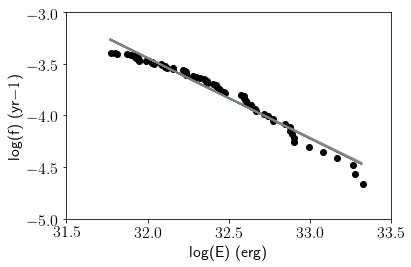

In [12]:
from matplotlib import rc, rcParams


rc('text', usetex=True)

font = {'family' : 'sans-serif',
        'sans-serif':['monospace'],
       # 'weight' : 'bold',
        'size'   : 16}

rc('font', **font)


header = ['Tmin','Tmax','alpha','beta','alpha_err',
          'beta_err','minenerg','maxenerg','n_obj','nflares',
          'corrected']
results = pd.DataFrame(columns=header)
specs2 = specs.drop(overlap)
plt.figure(figsize=(6,4))#8 5 
for (Tmin, Tmax, color, minenerg, maxenerg) in trange[cluster][2:3]:#fitset2[cluster][corr][:4]:
    #plt.figure(figsize=(8,5))
    print(Tmin,Tmax)
    #plt.title('Cumulative FFD: {}'.format(cluster))
    
    
#     p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='green',
#                                                     marker = '+',
#                                                     Tmin=Tmin, Tmax=Tmax, subset='temperature',
#                                                     Minenerg=minenerg, Maxenerg=maxenerg,
#                                                     fakes=False,onlyenergy=False)
    
#     l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
#                        var[0], var[1], minenerg, 
#                        maxenerg, n_obj, n_flares, False]]
#     t = pd.DataFrame(dict(list(zip(header,l))))
#     results = results.append(t,ignore_index=True)
    
    
#     p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='blue',
#                                                     marker = 'o',
#                                                     Tmin=Tmin, Tmax=Tmax, subset='temperature',
#                                                     Minenerg=minenerg, Maxenerg=maxenerg,
#                                                     fakes=fakes,onlyenergy=True)
    
#     l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
#                        var[0], var[1], minenerg, 
#                        maxenerg, n_obj, n_flares, fakes]]
#     t = pd.DataFrame(dict(list(zip(header,l))))
#     results = results.append(t,ignore_index=True)
    
    
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color=color,
                                                    marker = 'o',
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=True,onlyenergy=False)

    l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
                       var[0], var[1], minenerg, 
                       maxenerg, n_obj, n_flares, fakes]]
    t = pd.DataFrame(dict(list(zip(header,l))))
    results = results.append(t,ignore_index=True)
    
    
    plt.legend()
    plt.xlabel('log(E) (erg)')
    plt.ylabel('log(f) (yr${-1}$)')
    
    plt.ylim(-5.,-3)
    plt.xlim(31.5,33.5)
    plt.tight_layout()
    if fakes != True: corrected = 'un'
    else: corrected = ''
    loc = 'stars_shortlist/'
    path = '{3}{0}/results/{1}/plots/{2}corrected/'.format(cluster,test,corrected,loc)
    foldering(path)
    #plt.savefig('{4}/{0}_{1}_{2}_{3}_cum_FFD.png'.format(cluster,test,Tmin,Tmax,path),dpi=300)
    path = '{1}share/{0}corrected/'.format(corrected,loc)
    foldering(path)
    #plt.savefig('{4}/{0}_{1}_{2}_{3}_cum_FFD_build2.png'.format(cluster,test,Tmin,Tmax,path),dpi=300)
    #plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/FFDexmp.svg')
   # print_susp(specs, Tmin, Tmax,cluster, test,)
#         p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, color=color,
#                                                     Tmin=Tmin,Tmax=Tmax,subset='temperature',
#                                                     Minenerg=minenerg,Maxenerg=maxenerg,
#                                                     fakes=False)
#results.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.csv'.format(cluster,test))

In [ ]:
1/1.1006893981386663e-06

In [ ]:
results[results.n_obj<400].nflares.sum()

In [ ]:
results.to_csv('stars_shortlist/share/{0}_{1}_cum_FFD.csv'.format(cluster,test))

In [ ]:
sus = specs[specs.counts >5]
sus

In [ ]:

print_susp(sus, 3000, 3500, cluster, test,)

In [ ]:
def print_susp2(specs2, oid,cluster, test,):
    select_suspicious = specs2.loc[oid]

    try:
        flux, flares = import_flares(cluster, test, oid)
    except FileNotFoundError:
        pass
    plt.figure(figsize=(12,4))
    plt.plot(flux.time,(flux.flux_gap-flux.flux_model))
    
    
    for i, row in flares.iterrows():
        s,t =row.istart_no_sys_no_thruster,row.istop_no_sys_no_thruster
        plt.plot(flux.time.iloc[s:t+1],
                 (flux.flux_gap-flux.flux_model).iloc[s:t+1],
                 linewidth=2,
                 color='orange')
        plt.gca().fill_between(flux.time,
                              -flux.error,
                              flux.error,
                               color="#dddddd")
    
    f = flares[flares.count_true < 2.]
    print(flares.head())
    for i, row in f.iterrows():
        s,t =row.istart_no_sys_no_thruster,row.istop_no_sys_no_thruster
        plt.plot(flux.time.iloc[s:t+1],
                 (flux.flux_gap-flux.flux_model).iloc[s:t+1],
                 linewidth=2,
                 color='red')
        plt.gca().fill_between(flux.time,
                              -flux.error,
                              flux.error,
                               color="#dddddd")
        plt.title(oid)
    plt.xlim(2260,2290)
    plt.xlabel('Time (BJD - 2454833 days)')
    plt.ylabel('Flux (arb. u.)')
    plt.legend()
   # plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/k2sc_fail.png',
         #       dpi=300)


print_susp2(specs, 211046948,cluster, test)

In [ ]:
pass